# World football dataset

In [1]:
%matplotlib inline

In [2]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timezone
from kseval.models import iterate_dataset
from kseval.models.football import EloModel, TrueSkillModel, DATASET
from kseval.utils import data_path
from math import log

## Summary statistics

In [3]:
counter = collections.Counter()
n_obs = 0
for obs in iterate_dataset(DATASET):
    counter[obs["team1"]] += 1
    counter[obs["team2"]] += 1
    n_obs += 1

In [4]:
print("number of observations: {:,}".format(n_obs))
print("number of teams:        {:,}".format(len(counter)))

number of observations: 19,158
number of teams:        235


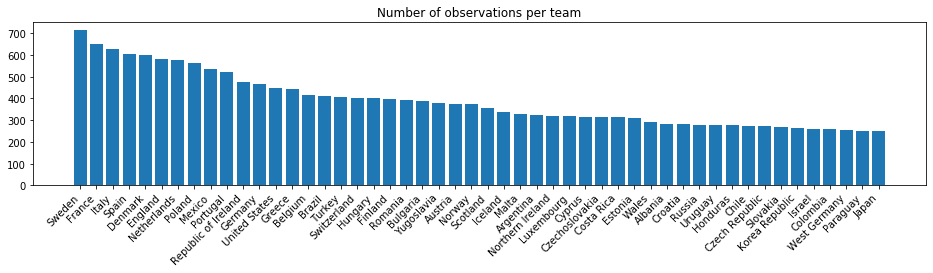

In [5]:
teams, counts = map(list, zip(*counter.most_common(n=50)))
indices = list(range(len(teams)))

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_xticks(indices)
ax.set_xticklabels(teams, rotation=45, ha="right")
ax.set_title("Number of observations per team");

In [6]:
counter = collections.Counter()
ts = list()
for obs in iterate_dataset(DATASET):
    dt = datetime.fromtimestamp(obs["t"], tz=timezone.utc)
    counter[dt.year] += 1
    ts.append(obs["t"])

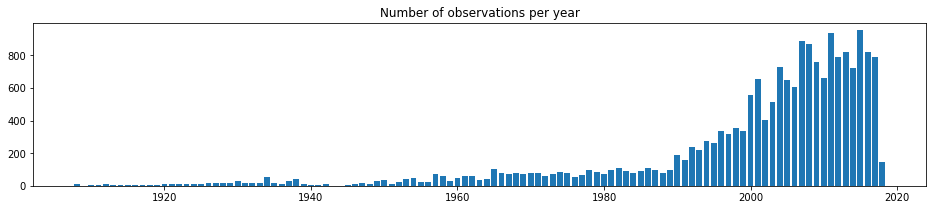

In [7]:
begin, end = min(counter), max(counter)
indices = np.arange(begin, end + 1, dtype=int)
counts = [counter[y] for y in indices]

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_title("Number of observations per year");

In [8]:
idx = int(0.7 * len(ts))
dt = datetime.fromtimestamp(ts[idx], tz=timezone.utc)
CUTOFF = datetime(dt.year, dt.month, dt.day, tzinfo=timezone.utc)

print("cutoff date: {:%Y-%m-%d}".format(CUTOFF))

cutoff date: 2011-06-03


## Evaluation of models

Elo

In [9]:
%%time
model = EloModel(margin=0.578, lr=0.196)
model.fit(cutoff=CUTOFF)
elo = model.evaluate(begin=CUTOFF)

CPU times: user 376 ms, sys: 3.86 ms, total: 379 ms
Wall time: 378 ms


TrueSkill

In [10]:
%%time
model = TrueSkillModel(margin=0.381, sigma=1.192, tau=0.0325)
model.fit(cutoff=CUTOFF)
trueskill = model.evaluate(begin=CUTOFF)

CPU times: user 7.67 s, sys: 19.4 ms, total: 7.69 s
Wall time: 7.69 s


In [11]:
res = {"random": {
    "n_obs": 0,
    "avg_ll": log(3),
    "avg_acc": 1/3
}}

for model, x in (("elo", elo), ("trueskill", trueskill)):
    res[model] = {
        "n_obs": x[0],
        "avg_ll": x[1] / x[0],
        "avg_acc": x[2] / x[0],
    }

for model in ("constant", "matern12", "matern32", "matern52", "ttt",
        "wiener", "logit", "difference", "count", "kl", "ha"):
    n_obs, log_loss, accuracy = 0, 0.0, 0.0
    for datum in iterate_dataset("eval/football-{}.txt".format(model)):
        n_obs += datum["n_obs"]
        log_loss += datum["log_loss"]
        accuracy += datum["accuracy"]
    res[model] = {
        "n_obs": n_obs,
        "avg_ll": log_loss / n_obs,
        "avg_acc": accuracy / n_obs,
    }

# Save results for plots.
with open(data_path("fig/football-perf.json"), "w") as f:
    json.dump(res, f)

    with open(data_path("fig/football-perf.json")) as f:
        res = json.load(f)
        
### Results for dynamics

In [12]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "elo", "trueskill", "constant", "matern12",
        "matern32", "matern52", "ttt", "wiener"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    1.099     0.333
elo         5759    0.950     0.551
trueskill   5759    0.937     0.554
constant    5759    0.929     0.558
matern12    5759    0.926     0.558
matern32    5759    0.926     0.559
matern52    5759    0.926     0.560
ttt         5759    0.926     0.559
wiener      5759    0.926     0.559


Best model is Matern12 (both in terms of marginal log likelihood and predictive log loss)

### Results for home-advantage

In [13]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <9}  {: >5}    {:.3f}     {:.3f}"

for model in ("random", "matern12", "ha"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random         0    1.099     0.333
matern12    5759    0.926     0.558
ha          5759    0.900     0.579


### Results for likelihoods

In [14]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <10}  {: >5}   {:.3f}     {:.3f}"

for model in ("random", "matern12", "logit", "difference", "count"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random          0   1.099     0.333
matern12     5759   0.926     0.558
logit        5759   0.926     0.559
difference   5759   0.927     0.562
count        5759   0.922     0.563


### Results for variational objectives

In [15]:
print("model      # obs  avg. ll  avg. acc")
print("-----------------------------------")
fmt = "{: <10}  {: >5}   {:.3f}     {:.3f}"

for model in ("random", "matern12", "kl"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model      # obs  avg. ll  avg. acc
-----------------------------------
random          0   1.099     0.333
matern12     5759   0.926     0.558
kl           5759   0.926     0.559
